# Física computacional: Tarea 2
Profesor: Pablo Benítez Llambay

Integrantes:
- Martín Raguileo Reyes
- Fernando Zamora Carrasco

#### **IMPORTANTE EJECUTAR ESTA CELDA PARA QUE SE EJECUTE EL CÓDIGO SIN PROBLEMAS**

In [1]:
import importlib
import subprocess
import sys

def install_if_missing(package, name=None):
    name = name or package
    try:
        importlib.import_module(package)
        print(f"'{package} ya está instalado.")
    except ImportError:
        print(f"Instalando '{package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", name])

packages = {
    "numpy": "numpy",
    "scipy": "scipy",
    "matplotlib": "matplotlib",
    "IPython": "ipython",
    "mpip4y": "mpi4py",
}

for pkg, name in packages.items():
    install_if_missing(pkg, name)

'numpy ya está instalado.
'scipy ya está instalado.
'matplotlib ya está instalado.
'IPython ya está instalado.
Instalando 'mpip4y...


In [2]:
import os
import shutil
import time
import numpy as np
from math import sqrt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import scipy.sparse
from scipy.sparse.linalg import spsolve, splu, SuperLU
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from typing import Callable, List, Dict
from IPython.display import Video, display, Math, Latex
from mpi4py import MPI
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Introducción

## Marco Teórico

La ecuación de calor en dos dimensiones está dada por:
$$
\frac{\partial T}{\partial t} = \alpha \left( \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right)
$$

y si agregamos una fuente de calor $ S(x, y, t)$, la ecuación queda:
$$
\frac{\partial T}{\partial t} = \alpha \left( \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right) + S(x, y, t)
$$

Para nuestro contexto, $T(x, y, t)$ es la temperatura en el punto $(x, y)$ en el tiempo $t$, $\alpha$ es la difusividad térmica del material, y $S(x, y, t)$ es la fuente de calor la cuál se define como:
$$

S(x, y, t) = P(t) \times
\begin{cases}
145.0 & \text{si } 0.4L \leq x \leq 0.6L \text{ y } 0.4L \leq y \leq 0.6L \\
0.0 & \text{en otro caso}
\end{cases}
$$

donde $P(t)$ es una función que simula una carga de trabajo con frecuencia $f$, definida como:
$$
P(t) = \dfrac{1}{2} \left( 1 + \text{sign}(\sin(2 \pi f t)) \right)
$$

Además, se tienen las siguientes condiciones de frontera:
- **Dominio**: una placa cuadrada de $L \times L$, con $L = 5 cm$.
- **Difusividad térmica**: $\alpha = 1.1 \times 10^{-4} m^2/s$.
- **Condición inicial**: la placa comienza a temperatura ambiente. Se asumirá que la temperatura ambiente es $T_{amb} = 0$, por lo que $T(x, y, 0) = 0$.
- **Condiciones de borde**: los cuatro bordes de la placa ($x = 0$, $x = L$, $y = 0$, $y = L$) están en contacto con un disipador ideal, que los mantiene a temperatura ambiente (condiciones de Dirichlet). Por lo tanto, $T(0, y, t) = T(L, y, t) = T(x, 0, t) = T(x, L, t) = 0$.
- **Frecuencia de la carga de trabajo**: $f_{1} = 0.5 Hz$, $f_{2} = 1 Hz$.

## 1. Formulación numérica (método explícito)

### Discretización de la ecuación de calor con fuente de calor

Para resolver la ecuación de calor con la fuente de calor utilizando el método explícito, discretizamos el dominio espacial y temporal. Sea $\Delta x$ y $\Delta y$ los pasos espaciales en las direcciones $x$ e $y$, respectivamente, y $\Delta t$ el paso temporal. Definimos una malla de puntos $(i, j)$ donde $i$ y $j$ son los índices espaciales correspondientes a las posiciones $x = i \Delta x$ y $y = j \Delta y$. La temperatura en el punto $(i, j)$ en el tiempo $n \Delta t$ se denota como $T_{i,j}^n$.

**Discretización del tiempo $\left(\frac{\partial T}{\partial t}\right)$:**
Utilizaremos la diferencia finita hacia adelante para aproximar la derivada temporal:
$$
\frac{\partial T}{\partial t} \approx \frac{T_{i,j}^{n+1} - T_{i,j}^n}{\Delta t}
$$

**Discretización del espacio $\left(\frac{\partial^2 T}{\partial x^2}, \frac{\partial^2 T}{\partial y^2}\right)$:**

Utilizaremos la diferencia finita centrada para aproximar las derivadas espaciales:
$$
\text{Para x tenemos:} \hspace{10pt} \frac{\partial^2 T}{\partial x^2} \approx \frac{T_{i+1,j}^n - 2T_{i,j}^n + T_{i-1,j}^n}{(\Delta x)^2}
$$
$$
\text{Para y tenemos:} \hspace{10pt} \frac{\partial^2 T}{\partial y^2} \approx \frac{T_{i,j+1}^n - 2T_{i,j}^n + T_{i,j-1}^n}{(\Delta y)^2}
$$

**Discretización de la fuente de calor $S(x, y, t)$:**
La fuente de calor en el punto $(i, j)$ en el tiempo $n \Delta t$ se denota como $S_{i,j}^n$ y se define según la ubicación en la malla:
$$
S_{i,j}^n = P(n \Delta t) \times
\begin{cases}
145.0 & \text{si } 0.4L \leq i \Delta x \leq 0.6L \text{ y } 0.4L \leq j \Delta y \leq 0.6L \\
0.0 & \text{en otro caso}
\end{cases}
$$

Luego de obtener las discretizaciones, sustituimos en la ecuación de calor con fuente de calor:
$$
\frac{T_{i,j}^{n+1} - T_{i,j}^n}{\Delta t} \approx \alpha \left( \frac{T_{i+1,j}^n - 2T_{i,j}^n + T_{i-1,j}^n}{(\Delta x)^2} + \frac{T_{i,j+1}^n - 2T_{i,j}^n + T_{i,j-1}^n}{(\Delta y)^2} \right) + S_{i,j}^n
$$

Despejando $T_{i,j}^{n+1}$, obtenemos la fórmula de actualización explícita:
$$
T_{i,j}^{n+1} = T_{i,j}^n + \alpha \Delta t \left( \frac{T_{i+1,j}^n - 2T_{i,j}^n + T_{i-1,j}^n}{(\Delta x)^2} + \frac{T_{i,j+1}^n - 2T_{i,j}^n + T_{i,j-1}^n}{(\Delta y)^2} \right) + S_{i,j}^n \Delta t
$$

Como estamos trabajando con una grilla uniforme de $N \times N$ puntos, podemos definir $\Delta x = \Delta y = h$. La fórmula de actualización se simplifica a:
$$
T_{i,j}^{n+1} = T_{i,j}^{n} + \dfrac{\alpha \Delta t}{h^2} \left( T_{i+1,j}^{n} + T_{i-1,j}^{n} + T_{i,j+1}^{n} + T_{i,j-1}^{n} - 4T_{i,j}^{n} \right) + S_{i,j}^{n} \Delta t
$$

### Análisis de estabilidad del método explícito con Von Neumann

#### Análisis de estabilidad 1D

Para analizar la estabilidad del método explícito, aplicamos el análisis de Von Neumann. Antes de determinar el criterio de estabilidad para la ecuación de calor 2D, consideremos el análisis de estabilidad para la ecuación de calor 1D. 

Consideremos el método explícito para la ecuación de calor 1D:
$$
T_{j}^{n+1} = T_{j}^{n} + \dfrac{\alpha \Delta t}{(\Delta x)^2} \left( T_{j+1}^{n} - 2T_{j}^{n} + T_{j-1}^{n} \right)
$$

Donde agrupamos los términos $T_{j}^{n}$ y definimos la constante $\mu = \dfrac{\alpha \Delta t}{(\Delta x)^2}$, por lo que la ecuación queda:
$$
T_{j}^{n+1} = (1 - 2\mu) T_{j}^{n} + \mu (T_{j+1}^{n} + T_{j-1}^{n})
$$

Luego, según lo propuesto en [[1]](#ref-landau), asumimos que los modos propios de la ecuación se pueden expresar como:
$$
T_{j}^{n} = \xi(k)^{n} e^{ik (j \Delta x)}
$$
donde $k$ es el vector de onda, $n$ es el índice temporal, $i = \sqrt{-1}$ es la unidad imaginaria, $j$ es el índice espacial y $\xi(k)$ es el factor de amplificación que depende de $k$. Luego, cada término de la ecuación de actualización se puede expresar de la siguiente manera:
$$
\begin{align*}
T_{j}^{n+1} &= \xi(k)^{n+1} e^{ik (j \Delta x)} = \xi(k) \cdot \left(\xi(k)^{n} e^{ik (j \Delta x)}\right) = \xi(k) T_{j}^{n} \\
T_{j+1}^{n} &= \xi(k)^{n} e^{ik ((j+1) \Delta x)} = \left(\xi(k)^{n}e^{ik(j \Delta x)} \right) \cdot e^{ik \Delta x} = T_{j}^{n} \cdot e^{ik \Delta x} \\
T_{j-1}^{n} &= \xi(k)^{n} e^{ik ((j-1) \Delta x)} = \left(\xi(k)^{n}e^{ik(j \Delta x)} \right) \cdot e^{-ik \Delta x} = T_{j}^{n} \cdot e^{-ik \Delta x}
\end{align*}
$$

Sustituyendo en la ecuación de actualización, se tiene:
$$
\xi(k) T_{j}^{n} = (1 - 2\mu) T_{j}^{n} + \mu \left( T_{j}^{n} e^{ik \Delta x} + T_{j}^{n} e^{-ik \Delta x} \right)
$$

Asumiendo que $T_{j}^{n} \neq 0$, podemos dividir ambos lados por $T_{j}^{n}$, obteniendo:
$$
\xi(k) = (1 - 2\mu) + \mu \left( e^{ik \Delta x} + e^{-ik \Delta x} \right)
$$

Usando la identidad de Euler, $e^{i\theta} + e^{-i\theta} = 2 \cos(\theta)$, podemos simplificar la expresión:
$$
\begin{align*}
\xi(k) &= 1 - 2\mu + \mu \left(2 \cos(k \Delta x) \right) \\
\xi(k) &= 1 - 2\mu + 2\mu \cos(k \Delta x) \\
\xi(k) &= 1 - 2\mu (1 - \cos(k \Delta x))
\end{align*}
$$

Luego, usando la identidad trigonométrica $1 - \cos(\theta) = 2 \sin^2\left(\frac{\theta}{2}\right)$, podemos reescribir $\xi(k)$ como:
$$
\xi(k) = 1 - 4\mu \sin^2\left(\frac{k \Delta x}{2}\right)
$$

Tal como indica [[1]](#ref-landau), para que el método sea estable, la amplitud de cualquier modo no debe crecer con el tiempo. Esto significa que la magnitud del factor de amplificación debe ser menor o igual a 1 para todos los valores de $k$:
$$
|\xi(k)| \leq 1
$$

Esto implica que:
1. $\xi(k) \leq 1$
2. $\xi(k) \geq -1$

Para la primera condición:
$$
\begin{align*}
1 - 4\mu \sin^2\left(\frac{k \Delta x}{2}\right) &\leq 1 \\
-4\mu \sin^2\left(\frac{k \Delta x}{2}\right) &\leq 0 \\
\end{align*}
$$
Dado que $\mu = \frac{\alpha \Delta t}{(\Delta x)^2} > 0$ y $\sin^2\left(\frac{k \Delta x}{2}\right) \geq 0$, esta condición se cumple siempre.

Por otro lado, para la segunda condición:
$$
\begin{align*}
1 - 4\mu \sin^2\left(\frac{k \Delta x}{2}\right) &\geq -1 \\
-4\mu \sin^2\left(\frac{k \Delta x}{2}\right) &\geq -2 \\
4\mu \sin^2\left(\frac{k \Delta x}{2}\right) &\leq 2 \\
\mu \sin^2\left(\frac{k \Delta x}{2}\right) &\leq \frac{1}{2} \\
\sin^2\left(\frac{k \Delta x}{2}\right) &\leq \dfrac{1}{2\mu}
\end{align*}
$$
Esta desigualdad debe cumplirse para todos los valores de $k$. La función $\sin^2\left(\frac{k \Delta x}{2}\right)$ alcanza su valor máximo de 1 cuando $\frac{k \Delta x}{2} = \frac{\pi}{2}$, es decir, cuando $k \Delta x = \pi$. Por lo tanto, para garantizar la estabilidad para todos los modos, debemos imponer:
$$
1 \leq \dfrac{1}{2\mu} \implies  \mu \leq \frac{1}{2}
$$
Sustituyendo el valor de $\mu$, obtenemos el criterio de estabilidad para el método explícito aplicado a la ecuación de calor 1D:
$$
\frac{\alpha \Delta t}{(\Delta x)^2} \leq \frac{1}{2} \implies \Delta t \leq \frac{(\Delta x)^2}{2\alpha}
$$

#### Análisis de estabilidad 2D

Una vez obtenido el criterio de estabilidad para la ecuación de calor 1D, podemos extender este análisis a la ecuación de calor 2D. La fórmula de actualización explícita para la ecuación de calor 2D es:
$$
T_{j,l}^{n+1} = T_{j,l}^{n} + \dfrac{\alpha \Delta t}{h^2} \left( T_{j+1,l}^{n} + T_{j-1,l}^{n} + T_{j,l+1}^{n} + T_{j,l-1}^{n} - 4T_{j,l}^{n} \right) + S_{j,l}^{n} \Delta t
$$
donde $j$ y $l$ son los índices espaciales en las direcciones $x$ e $y$, respectivamente, $n$ es el índice temporal, y $h$ es el tamaño del paso espacial (asumiendo una malla uniforme, $h = \Delta x = \Delta y$). Además, $S_{j,l}^{n} = 0$ para el análisis de estabilidad, ya que la fuente de calor no afecta la estabilidad del método y $\mu = \frac{\alpha \Delta t}{h^2}$.

En consiguiente, agrupamos los términos $T_{j,l}^{n}$ y obtenemos:
$$
T_{j,l}^{n+1} = (1 - 4\mu) T_{j,l}^{n} + \mu \left( T_{j+1,l}^{n} + T_{j-1,l}^{n} + T_{j,l+1}^{n} + T_{j,l-1}^{n} \right)
$$

Luego, extendemos la suposición del modo propio propuesto en [[1]](#ref-landau) a dos dimensiones espaciales. Ahora la temperatura depende de los índices espaciales $j$ y $l$, por lo que necesitamos dos vectores de onda, $k_x$ y $k_y$, entonces los modos propios se pueden expresar como:
$$
T_{j,l}^{n} = \xi(k_{x}, k_{y})^{n} \cdot e^{i \left(k_{x} jh + k_{y} l h\right)}
$$
donde $k_x$ y $k_y$ son los vectores de onda en las direcciones $x$ e $y$, respectivamente, $n$ es el índice temporal, $j$ y $l$ son los índices espaciales, $i = \sqrt{-1}$ es la unidad imaginaria, $h$ es el tamaño del paso espacial y $\xi(k_x, k_y)$ es el factor de amplificación que depende de ambos vectores de onda. Luego, cada término de la ecuación de actualización se puede expresar de la siguiente manera:
$$
\begin{align*}
T_{j,l}^{n+1} &= \xi(k_{x}, k_{y})^{n+1} e^{i \left(k_{x} jh + k_{y} l h\right)} = \xi(k_{x}, k_{y}) \cdot \left(\xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} l h\right)}\right) = \xi(k_{x}, k_{y}) T_{j,l}^{n} \\
T_{j+1,l}^{n} &= \xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} (j+1)h + k_{y} l h\right)} = \left(\xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} l h\right)}\right) \cdot e^{i k_{x} h} = T_{j,l}^{n} \cdot e^{i k_{x} h} \\
T_{j-1,l}^{n} &= \xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} (j-1)h + k_{y} l h\right)} = \left(\xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} l h\right)}\right) \cdot e^{-i k_{x} h} = T_{j,l}^{n} \cdot e^{-i k_{x} h} \\
T_{j,l+1}^{n} &= \xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} (l+1) h\right)} = \left(\xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} l h\right)}\right) \cdot e^{i k_{y} h} = T_{j,l}^{n} \cdot e^{i k_{y} h} \\
T_{j,l-1}^{n} &= \xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} (l-1) h\right)} = \left(\xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} l h\right)}\right) \cdot e^{-i k_{y} h} = T_{j,l}^{n} \cdot e^{-i k_{y} h}
\end{align*}
$$

Sustituyendo en la ecuación de actualización, se tiene:
$$
\xi(k_{x}, k_{y}) T_{j,l}^{n} = (1 - 4\mu) T_{j,l}^{n} + \mu \left( T_{j,l}^{n} e^{i k_{x} h} + T_{j,l}^{n} e^{-i k_{x} h} + T_{j,l}^{n} e^{i k_{y} h} + T_{j,l}^{n} e^{-i k_{y} h} \right)
$$

Asumiendo que $T_{j,l}^{n} \neq 0$, podemos dividir ambos lados por $T_{j,l}^{n}$, obteniendo:
$$
\xi(k_{x}, k_{y}) = (1 - 4\mu) + \mu \left( e^{i k_{x} h} + e^{-i k_{x} h} + e^{i k_{y} h} + e^{-i k_{y} h} \right)
$$

Usando la identidad de Euler, $e^{i\theta} + e^{-i\theta} = 2 \cos(\theta)$, podemos simplificar la expresión:
$$
\begin{align*}
\xi(k_{x}, k_{y}) &= 1 - 4\mu + \mu \left( 2 \cos(k_{x} h) + 2 \cos(k_{y} h) \right) \\
\xi(k_{x}, k_{y}) &= 1 - 4\mu + 2\mu \left( \cos(k_{x} h) + \cos(k_{y} h) \right) \\
\xi(k_{x}, k_{y}) &= 1 - 2\mu \left( 2 - \cos(k_{x} h) - \cos(k_{y} h) \right) \\
\xi(k_{x}, k_{y}) &= 1 - 2\mu \left( 1 - \cos(k_{x} h)\right) - 2\mu \left( 1 - \cos(k_{y} h) \right)
\end{align*}
$$

Luego, usando la identidad trigonométrica $1 - \cos(\theta) = 2 \sin^2\left(\frac{\theta}{2}\right)$, podemos reescribir $\xi(k_{x}, k_{y})$ como:
$$
\begin{align*}
\xi(k_{x}, k_{y}) &= 1 - 4\mu \sin^{2} \left( \dfrac{k_{x}h}{2} \right) - 4\mu \sin^{2} \left( \dfrac{k_{y}h}{2} \right) \\
\xi(k_{x}, k_{y}) &= 1 - 4\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right]
\end{align*}
$$

Nuevamente, tal como indica [[1]](#ref-landau), para que el método sea estable, la magnitud del factor de amplificación debe ser menor o igual a 1 para todos los valores de $k_x$ y $k_y$, es decir:
$$
|\xi(k_{x}, k_{y})| \leq 1
$$

Esto implica que:
1. $\xi(k_{x}, k_{y}) \leq 1$
2. $\xi(k_{x}, k_{y}) \geq -1$

Para la primera condición:
$$
\begin{align*}
1 - 4\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right] &\leq 1 \\
-4\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right] &\leq 0 \\
\end{align*}
$$
dado que $\mu = \frac{\alpha \Delta t}{h^2} > 0$ y $\sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \geq 0$, esta condición se cumple siempre.

Por otro lado, para la segunda condición:
$$
\begin{align*}
1 - 4\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right] &\geq -1 \\
-4\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right] &\geq -2 \\
4\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right] &\leq 2 \\
\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right] &\leq \frac{1}{2} \\
\sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) &\leq \dfrac{1}{2\mu}
\end{align*}
$$

Esta desigualdad debe cumplirse para todos los valores de $k_x$ y $k_y$. La función $\sin^{2} \left(\frac{k_{x}h}{2}\right) + \sin^{2} \left(\frac{k_{y}h}{2}\right)$ alcanza su valor máximo de 2 cuando ambos términos son iguales a 1, es decir, cuando $\frac{k_{x}h}{2} = \frac{\pi}{2}$ y $\frac{k_{y}h}{2} = \frac{\pi}{2}$, o, equivalentemente, cuando $k_{x}h = \pi$ y $k_{y}h = \pi$. Por lo tanto, para garantizar la estabilidad para todos los modos, debemos imponer:
$$
2 \leq \dfrac{1}{2\mu} \implies 2\mu \leq \dfrac{1}{2} \implies \mu \leq \frac{1}{4}
$$

Sustituyendo el valor de $\mu$, obtenemos el criterio de estabilidad para el método explícito aplicado a la ecuación de calor 2D:
$$
\frac{\alpha \Delta t}{h^2} \leq \frac{1}{4} \implies \Delta t \leq \frac{h^2}{4\alpha}
$$
o, para de forma más general (si $\Delta x \neq \Delta y$):
$$
\alpha \Delta t \left( \frac{1}{(\Delta x)^2} + \frac{1}{(\Delta y)^2} \right) \leq \dfrac{1}{2}
$$

### Elección del paso temporal $\Delta t$

Entonces, dado el criterio de estabilidad obtenido ($\Delta t \leq \frac{h^2}{4\alpha}$), podemos elegir un valor adecuado para el paso temporal $\Delta t$ en función del tamaño del paso espacial $h$ y la difusividad térmica $\alpha$. Utilizando los parámetros dados en el enunciado:
- $L = 5 cm = 0.05 m$
- $\alpha = 1.1 \times 10^{-4} m^2/s$
- $N \geq 512$, pero, por simplicidad, tomaremos $N = 512$

Calculamos el tamaño del paso espacial $h$:
$$
h = \frac{L}{N} = \frac{0.05 \hspace{2pt} [m]}{512} \approx 9.7656 \times 10^{-5} \hspace{2pt} [m]
$$

Luego, calculamos el valor máximo permitido para $\Delta t$ según el criterio de estabilidad:
$$
\begin{align*}
\Delta t_{max} &= \frac{h^2}{4\alpha} \\
&= \frac{(9.7656 \times 10^{-5} \hspace{2pt} [m])^2}{4 \times \left( 1.1 \times 10^{-4} \hspace{2pt} [m^2/s] \right)} \\
&\approx 2.2676 \times 10^{-5} \hspace{2pt} [s]
\end{align*}
$$

Por lo tanto, para garantizar la estabilidad del método explícito, debemos elegir un paso temporal $\Delta t$ que sea menor o igual a $2.2676 \times 10^{-5} \hspace{2pt} [s]$. Para mayor seguridad, podemos elegir un valor ligeramente menor, por ejemplo:
$$
\Delta t = 2.0 \times 10^{-5} \hspace{2pt} [s]
$$

## 2. Implementación serial (base)

In [3]:
## Definición de parámetros
N = 512         # Resolución de la grilla
L = 0.05        # Largo de la placa [m]
alpha = 1.1e-4  # Difusividad térmica del cobre [m^2/s]
dt = 2.0e-5     # Paso del tiempo [s]
t_final = 5     # Tiempo de simulación
f_1 = 0.5       # Frecuencia de la carga lenta [Hz] 
f_2 = 10.0      # Frecuencia de la carga rápida [Hz]

## Función de carga P(t)
def P(t:float, f:float) -> float:
    """
    Calcula la función de carga pulsante P(t). 
    """
    return 0.5 * (1 + np.sign(np.sin(2 * np.pi * f * t)))

In [4]:
## Función de simulación explícita
def run_simulation_explicit(N:int, L:float, alpha:float, dt:float, t_final:float, f:float) -> np.ndarray:
    """
    Ejecuta la simulación explícita de transferencia de calor para una frecuencia f dada.
    
    Retorna:
    - T_1: Tiempo de ejecución de la simulación [s]
    - time_history: Array de tiempos [s]
    - T_center_history: Array de temperaturas del punto central [K]
    """

    # Parámetros derivados
    h = L / N
    mu = (alpha * dt) / (h**2)
    n_steps = int(t_final / dt)

    if mu > 0.25:
        print(f"Advertencia: La simulación puede ser inestable (mu = {mu:.4f} > 0.25).")
        return 0.0, [], []

    print(f"Ejecutando simulación explícita con f = {f} Hz...")
    print(f"Grilla: {N} x {N}, L = {L:.2f} [m], dt = {dt:.2e} [s]")
    print(f"t_final = {t_final} [s], Pasos = {n_steps}, mu = {mu:.4f}")

    # Inicialización de la grilla de temperatura
    T = np.zeros((N, N), dtype=np.float64)

    # Máscara espacial para S(x, y, t)
    i_min, i_max = int(0.4 * N), int(0.6 * N)
    j_min, j_max = int(0.4 * N), int(0.6 * N)
    S_mask = np.zeros((N, N), dtype=np.float64)
    S_mask[i_min:i_max, j_min:j_max] = 145.0    # [K/s]

    # Historial de tiempo y temperatura en el centro
    T_center_history = np.zeros(n_steps)
    time_history = np.zeros(n_steps)
    T_center_idx = N // 2

    # Bucle principal de la simulación
    start_time = time.time()

    for n in range(n_steps):
        t = n * dt
        
        # Calcular la carga actual P(t)
        Pt = P(t, f)

        # Calcular el Laplaciano discreto (vectorizado)
        T_laplacian = (
            T[2:,   1:-1] +  # T(i+1, j)
            T[0:-2, 1:-1] +  # T(i-1, j)
            T[1:-1, 2:  ] +  # T(i, j+1)
            T[1:-1, 0:-2] -  # T(i, j-1)
            4 * T[1:-1, 1:-1] # -4 * T(i, j)
        )

        # Calcular el término fuente para los puntos internos
        S_internal = S_mask[1:-1, 1:-1] * Pt

        # Actualizar T para el tiempo n+1 (solo puntos internos)
        T[1:-1, 1:-1] += mu * T_laplacian + S_internal * dt

        # Almacenar datos del centro
        T_center_history[n] = T[T_center_idx, T_center_idx]
        time_history[n] = t

    end_time = time.time()
    T_1 = end_time - start_time

    print(f"Simulación ({f} Hz) completa en {T_1:.2f} segundos ({T_1 / 60:.2f} minutos).\n")

    return T_1, time_history, T_center_history

In [5]:
T_1_f1, time_history_f1, T_center_history_f1 = run_simulation_explicit(N, L, alpha, dt, t_final, f_1)
T_1_f2, time_history_f2, T_center_history_f2 = run_simulation_explicit(N, L, alpha, dt, t_final, f_2)

Ejecutando simulación explícita con f = 0.5 Hz...
Grilla: 512 x 512, L = 0.05 [m], dt = 2.00e-05 [s]
t_final = 5 [s], Pasos = 249999, mu = 0.2307
Simulación (0.5 Hz) completa en 943.29 segundos (15.72 minutos).

Ejecutando simulación explícita con f = 10.0 Hz...
Grilla: 512 x 512, L = 0.05 [m], dt = 2.00e-05 [s]
t_final = 5 [s], Pasos = 249999, mu = 0.2307
Simulación (10.0 Hz) completa en 903.08 segundos (15.05 minutos).



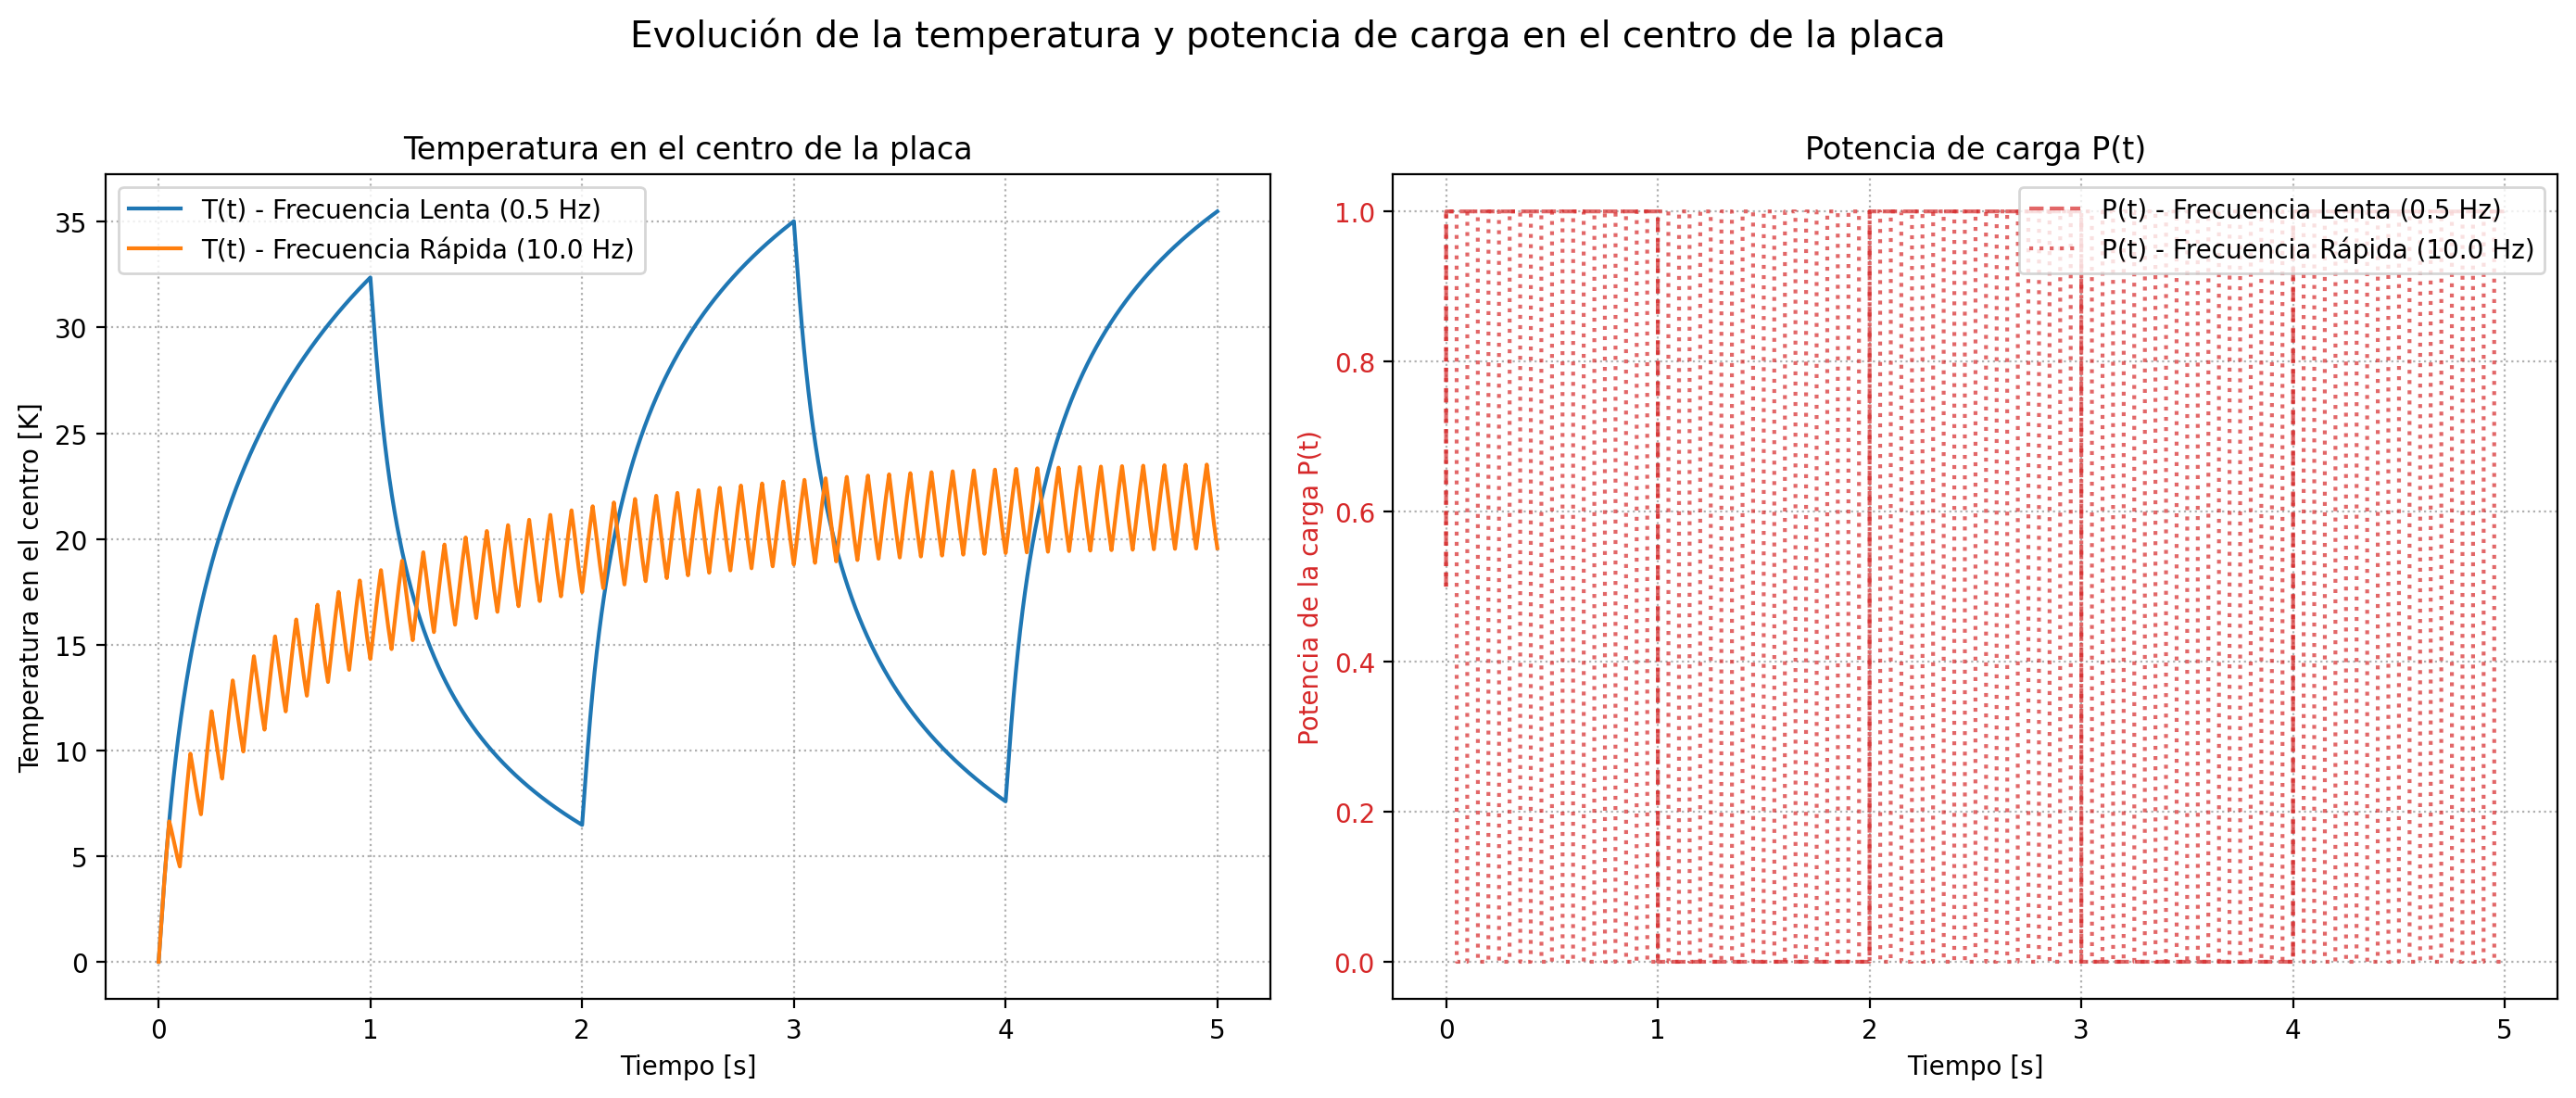

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Temperatura en el centro
color_lenta = 'tab:blue'
color_rapida = 'tab:orange'

ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('Temperatura en el centro [K]')
ax1.plot(time_history_f1, T_center_history_f1, color=color_lenta, 
         label=f'T(t) - Frecuencia Lenta ({f_1} Hz)')
ax1.plot(time_history_f2, T_center_history_f2, color=color_rapida, 
         label=f'T(t) - Frecuencia Rápida ({f_2} Hz)')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle=':')
ax1.set_title('Temperatura en el centro de la placa')

# Potencia de la carga
color_potencia = 'tab:red'

ax2.set_xlabel('Tiempo [s]')
ax2.set_ylabel('Potencia de la carga P(t)', color=color_potencia)
P_values_f1 = P(time_history_f1, f_1)
P_values_f2 = P(time_history_f2, f_2)
ax2.plot(time_history_f1, P_values_f1, color=color_potencia, 
         linestyle='--', alpha=0.7, label=f'P(t) - Frecuencia Lenta ({f_1} Hz)')
ax2.plot(time_history_f2, P_values_f2, color=color_potencia, 
         linestyle=':', alpha=0.7, label=f'P(t) - Frecuencia Rápida ({f_2} Hz)')
ax2.tick_params(axis='y', labelcolor=color_potencia)
ax2.legend(loc='upper right')
ax2.grid(True, linestyle=':')
ax2.set_title('Potencia de carga P(t)')

# Ajustes finales
fig.suptitle('Evolución de la temperatura y potencia de carga en el centro de la placa', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])

os.makedirs('./media', exist_ok=True)
output_file = './media/analisis_frecuencias.png'
plt.savefig(output_file, dpi=300)
plt.show()


## 3. Implementación paralela (MPI)

Para que MPI utilice múltiples núcleos, es necesario ejecutar el código desde la terminal utilizando el comando `mpirun` o `mpiexec`, especificando el número de procesos que se desean utilizar. Por ejemplo, para ejecutar el programa con 4 procesos, se puede usar el siguiente comando:

```bash
mpiexec -n 4 python programa.py
```

Donde `programa.py` es el nombre del archivo que contiene el código MPI.

A continuación, se presenta el código completo de la implementación paralela utilizando MPI para resolver la ecuación de calor en 2D con una fuente de calor variable en el tiempo, utilizando el método explícito y considerando las condiciones de frontera y la fuente de calor descritas en el enunciado.


### Estrategia de paralelización y comunicación MPI

La estrategia de paralelización utilizada se basa en una **descomposición de dominio 1D**, tal como se describen en la celda siguiente y en el script localizado en `utils/mpi_simulation.py`. Para ello, se realizan los siguientes pasos. En primer lugar, se divide la malla 2D de tamaño \(N \times N\) en $P$ franjas horizontales, donde $P$ es el número de procesos disponibles (el cuál, al utilizar MPI, corresponde a `size = comm.Get_size()`, los cuales están relacionados a la cantidad de núcleos que se dedican a la computación). 

En segundo lugar, cada proceso `rank` de ($0$ a $P-1$) se vuelve responsable de una única franja. El número de filas en esta franja local se calcula como `local_N = N // size`, asumiendo que $N$ es divisible por $P$. Cada proceso maneja una submatriz de tamaño `local_N x N`. Por ejemplo, en una simulación de $512 \times 512$ con $P = 8$ procesos, cada `rank` es responsable de una sub-grilla local de $64 \times 512$.

En tercer lugar, cada proceso instancia su propia grilla local `T_local`. Esta grilla es de tamaño `(local_N + 2, N)`. Las $N$ columnas de mantienen completas, ya que la dependencia de daatos del *stencil* (el Laplaciano) en la dirección $x$ (`T[1:-1, 2:]` y `T[1:-1, 0:-2]`) se puede calcular localmente sin necesidad de comunicación entre procesos. Cabe destacar que las filas adicionales (una fila extra en la parte superior e inferior) son necesarias para almacenar los datos de las filas vecinas que pertenecen a otros procesos. Estas filas adicionales se denominan **celdas fantasma** o **ghost cells**.

En cuarto lugar, la parte principal del cómputo (el cálculo del Laplaciano y la actualización de $T$) es idéntica a la implementación serial. Ésta se realiza de forma vectorizada utilizando NumPy; lo que mejora significativamente el rendimiento, sobre la sub-grilla `T_local[1:-1, 1:-1]`, que corresponde a las celdas "reales" o "propias" de cada proceso.

El principal desafío de la descomposición de dominio es que el cálculo del Laplaciano en los bordes de cada franja local depende de los valores de las filas adyacentes que pertenecen a otros procesos. Para resolver este problema se utiliza el concepto de **celdas fantasma** (**ghost cells**). Las dos filas adicionales en `T_local` (índices `0` y `-1`) actúan como un *buffer* para almacenar los valores de las filas vecinas de otros procesos. En particular:
- `T_local[0, :]` (fila fantasma superior) almacena los valores de la última fila de la franja del proceso `rank - 1`.
- `T_local[1:-1, :]` (filas reales) almacena los valores de la franja local del proceso.
- `T_local[-1, :]` (fila fantasma inferior) almacena los valores de la primera fila de la franja del proceso `rank + 1`.

Luego, para poblar estas celdas fantasma, se implementa un intercambio de datos entre procesos al inicio de cada iteración del bucle temporal (`for n in range(num_steps):`). Esto asegura que los datos necesarios estén disponibles localmente antes de realizar el cómputo del Laplaciano. El intercambio de datos se realiza utilizando las funciones `comm.Sendrecv` de MPI, que permiten enviar y recibir datos simultáneamente entre procesos vecinos. En particular, se realizan dos intercambios por paso:

**a.** Cada proceso envía su primera fila real (`T_local[1, :]`) a su vecino de arriba (`up_neighbor`) y, simultáneamente, recibe los datos de ese vecino en su celda fantasma superior (`T_local[0, :]`).
```python
comm.Sendrecv(sendbuf=T_local[1, :], dest=up_neighbor,
              recvbuf=T_local[0, :], source=up_neighbor)
```
**b.** Cada proceso envía su última fila real (`T_local[-2, :]`) a su vecino de abajo (`down_neighbor`) y, simultáneamente, recibe los datos de ese vecino en su celda fantasma inferior (`T_local[-1, :]`).
```python
comm.Sendrecv(sendbuf=T_local[-2, :], dest=down_neighbor,
              recvbuf=T_local[-1, :], source=down_neighbor)
```

Por último, el manejo de los bordes globales (los procesos `rank = 0` y `rank = size -1`) se logra usando `MPI.PROC_NULL` como destino o fuente en las operaciones de envío/recepción. Esto asegura que no se realicen comunicaciones innecesarias para los bordes que están en contacto con el disipador ideal (condiciones de Dirichlet). Para `rank = 0`, no hay vecino arriba, por lo que `up_neighbor = MPI.PROC_NULL`. De manera similar, para `rank = size - 1`, no hay vecino abajo, por lo que `down_neighbor = MPI.PROC_NULL`. Como resultado, las celdas fantasma correspondientes permanecen en su valor inicial (cero), cumpliendo así con las condiciones de frontera. Esta estrategia de descomposición y comunicación minimiza la sobrecarga de comunicación, ya que el costoso cómputo de NumPy se paraleliza ($\propto 1/P$), mientras que la comunicación se limita a dos operaciones de envío/recepción por proceso en cada paso temporal.

### Código MPI para la ecuación de calor en 2D con fuente de calor variable en el tiempo

```python
import numpy as np
import time
import sys
from mpi4py import MPI

# Función de Carga P(t)
def P(t: float, f: float) -> float:
  """
  Calcula la función de carga pulsante P(t).
  """
  return 0.5 * (1 + np.sign(np.sin(2 * np.pi * f * t)))

# Función Principal de Simulación (MPI)
def run_simulation_mpi(comm, N, L, alpha, dt, t_final, f):
  """
  Ejecuta la simulación MPI de transferencia de calor para una frecuencia f dada.
  
  Retorna (solo en rank 0):
  - T_p: Tiempo de ejecución de la simulación [s]
  - time_history: Array de tiempos [s]
  - T_center_history: Array de temperaturas del punto central [K]
  """
  
  # 1. Inicialización MPI y Geometría
  rank = comm.Get_rank()
  size = comm.Get_size()

  h = L / N
  mu = (alpha * dt) / (h**2)
  n_steps = int(t_final / dt)
  
  local_N = N // size
  start_row = rank * local_N
  
  if rank == 0:
    print(f"Iniciando Simulación MPI (f={f} Hz, size={size})")
    print(f"Grilla Global: {N}x{N}, Grilla Local: {local_N}x{N}")
    print(f"dt = {dt:.2e} s, Pasos = {n_steps}, mu = {mu:.4f}")

  if mu > 0.25:
    if rank == 0:
      print("ADVERTENCIA: Simulación INESTABLE (mu > 0.25)")
    comm.Abort() # Detener todos los procesos si es inestable
      
  # 2. Inicialización de Grillas Locales
  T_local = np.zeros((local_N + 2, N), dtype=np.float64) # +2 celdas fantasma
  S_mask_local = np.zeros((local_N + 2, N), dtype=np.float64)

  global_i_min, global_i_max = int(0.4 * N), int(0.6 * N)
  j_min, j_max = int(0.4 * N), int(0.6 * N)

  i_start = max(0, global_i_min - start_row) + 1  # +1 por fantasma
  i_end = min(local_N, global_i_max - start_row) + 1 # +1 por fantasma

  if i_start < i_end:
    S_mask_local[i_start:i_end, j_min:j_max] = 145.0

  # 3. Definir Vecinos
  up_neighbor = rank - 1 if rank > 0 else MPI.PROC_NULL
  down_neighbor = rank + 1 if rank < size - 1 else MPI.PROC_NULL

  # 4. Lógica de Recolección
  # Encontrar qué rank posee el centro
  center_row_global = N // 2
  center_col_local = N // 2
  center_rank = center_row_global // local_N
  local_center_row_idx = (center_row_global % local_N) + 1 # +1 por fantasma
  
  T_center_history = None
  time_history = np.linspace(0, t_final, n_steps) # Todos calculan esto

  if rank == center_rank:
    T_center_history = np.zeros(n_steps, dtype=np.float64) # Solo 1 rank almacena

  # 5. Bucle Principal de Simulación
  comm.Barrier()
  start_time = MPI.Wtime()

  for n in range(n_steps):
    # 1. Comunicación (Intercambio de Halos)
    comm.Sendrecv(sendbuf=T_local[1, :], dest=up_neighbor,
                  recvbuf=T_local[0, :], source=up_neighbor)
    comm.Sendrecv(sendbuf=T_local[-2, :], dest=down_neighbor,
                  recvbuf=T_local[-1, :], source=down_neighbor)
    
    t = n * dt
    Pt = P(t, f)

    # 2. Cálculo (Vectorizado)
    T_laplacian_local = (
      T_local[2:,   1:-1] +
      T_local[0:-2, 1:-1] + 
      T_local[1:-1, 2:  ] +
      T_local[1:-1, 0:-2] - 
      4 * T_local[1:-1, 1:-1]
    )
    S_internal_local = S_mask_local[1:-1, 1:-1] * Pt

    # 3. Actualización
    T_local[1:-1, 1:-1] += mu * T_laplacian_local + S_internal_local * dt

    # 4. Recolección de datos (solo el rank propietario)
    if rank == center_rank:
        T_center_history[n] = T_local[local_center_row_idx, center_col_local]

  comm.Barrier()
  end_time = MPI.Wtime()
  T_p = end_time - start_time

  # 6. Recolección Final de Datos en Rank 0
  if rank == 0:
    if center_rank == 0:
      # Rank 0 ya tiene los datos
      pass
    else:
      # Rank 0 necesita recibir los datos del center_rank
      T_center_history = np.zeros(n_steps, dtype=np.float64) # Preparar buffer
      comm.Recv(T_center_history, source=center_rank, tag=11)
    
    print(f"Simulación (f={f} Hz) completada.")
    print(f"Tiempo de ejecución paralelo ($T_p$): {T_p:.4f} segundos.")
    
    # Guardar resultados en un archivo para que el notebook los lea
    output_filename = f'results_f_{f}_p_{size}.npz'
    np.savez(output_filename, 
              time=time_history, 
              temp=T_center_history, 
              T_exec=T_p)
    print(f"Resultados guardados en: {output_filename}")
      
  elif rank == center_rank:
    # El rank propietario envía sus datos al rank 0
    comm.Send(T_center_history, dest=0, tag=11)

# Bloque de Ejecución Principal
if __name__ == "__main__":
  
  # 1. Leer Frecuencia desde Argumentos de Línea de Comandos
  if len(sys.argv) != 2:
    if MPI.COMM_WORLD.Get_rank() == 0:
      print("Error: El script debe llamarse con una frecuencia como argumento.")
      print(f"Ejemplo: mpiexec -n 8 python {sys.argv[0]} 0.5")
    MPI.COMM_WORLD.Abort()
      
  f_arg = float(sys.argv[1]) # Leer f (0.5 o 10.0)

  # 2. Parámetros Globales
  N = 512
  L = 0.05
  alpha = 1.1e-4
  dt = 2.0e-5
  t_final = 5.0

  # 3. Inicializar MPI y Ejecutar Simulación
  comm = MPI.COMM_WORLD
  run_simulation_mpi(comm, N, L, alpha, dt, t_final, f=f_arg)
```

### Ejecución del código MPI

Por consiguiente, se guardó el código de la celda anterior en un archivo llamado `mpi_simulation.py` en la carpeta `utils` que se encuentra en el mismo directorio que este notebook. Luego, se ejecutó el archivo desde la terminal utilizando `mpiexec` con el número máximo de núcleos que mi computadora puede utilizar (en este caso, 16 hilos), para obtener los resultados paralelos.

Entonces, para ejecutar la simulación paralela con 16 núcleos, se utilizó el siguiente comando en la terminal:
```bash
mpiexec -n 16 python utils/mpi_simulation.py 0.5
```

In [7]:
!mpiexec -n 16 python ./utils/mpi_simulation.py 0.5

Iniciando Simulación MPI (f=0.5 Hz, size=16)
Simulación (f=0.5 Hz) completada en 92.8728 segundos (1.5479 minutos).
Resultados guardados en: ./media\mpi_results_f_0.50_p_16.npz



In [8]:
!mpiexec -n 16 python ./utils/mpi_simulation.py 10.0

Iniciando Simulación MPI (f=10.0 Hz, size=16)
Simulación (f=10.0 Hz) completada en 108.7687 segundos (1.8128 minutos).
Resultados guardados en: ./media\mpi_results_f_10.00_p_16.npz



## 4. Análisis de rendimiento

In [9]:
p_values = [2, 4, 8, 16] 
times_p = {} # Diccionario para guardar los tiempos

print(f"Utilizaremos la simuación con carga rápida (f = {f_2} Hz).")

script_path = './utils/mpi_simulation.py'
output_dir = './media/'

print(f"Recolectando datos de rendimiento (T_1 = {T_1_f2:.2f} [s])...\n")

for p in p_values:
    print(f"Ejecutando simulación paralela con {p} procesos...")
    !mpiexec -n {p} python {script_path} {f_2}

    output_filename = os.path.join(output_dir, f"mpi_results_f_{f_2:.2f}_p_{p}.npz")

    try:
        data = np.load(output_filename)
        T_p = data['T_exec'].item()
        times_p[p] = T_p
        # print(f"Tiempo paralelo T_p ({p} procesos): {T_p:.2f} [s]\n")
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo {output_filename}.")
        print("Asegúrese de que la simulación se haya ejecutado correctamente.\n")
        break

print("Recolección de datos completa.")
print(times_p)

Utilizaremos la simuación con carga rápida (f = 10.0 Hz).
Recolectando datos de rendimiento (T_1 = 903.08 [s])...

Ejecutando simulación paralela con 2 procesos...
Iniciando Simulación MPI (f=10.0 Hz, size=2)
Simulación (f=10.0 Hz) completada en 666.2436 segundos (11.1041 minutos).
Resultados guardados en: ./media\mpi_results_f_10.00_p_2.npz

Ejecutando simulación paralela con 4 procesos...
Iniciando Simulación MPI (f=10.0 Hz, size=4)
Simulación (f=10.0 Hz) completada en 329.7570 segundos (5.4960 minutos).
Resultados guardados en: ./media\mpi_results_f_10.00_p_4.npz

Ejecutando simulación paralela con 8 procesos...
Iniciando Simulación MPI (f=10.0 Hz, size=8)
Simulación (f=10.0 Hz) completada en 189.5083 segundos (3.1585 minutos).
Resultados guardados en: ./media\mpi_results_f_10.00_p_8.npz

Ejecutando simulación paralela con 16 procesos...
Iniciando Simulación MPI (f=10.0 Hz, size=16)
Simulación (f=10.0 Hz) completada en 110.9182 segundos (1.8486 minutos).
Resultados guardados en: ./m

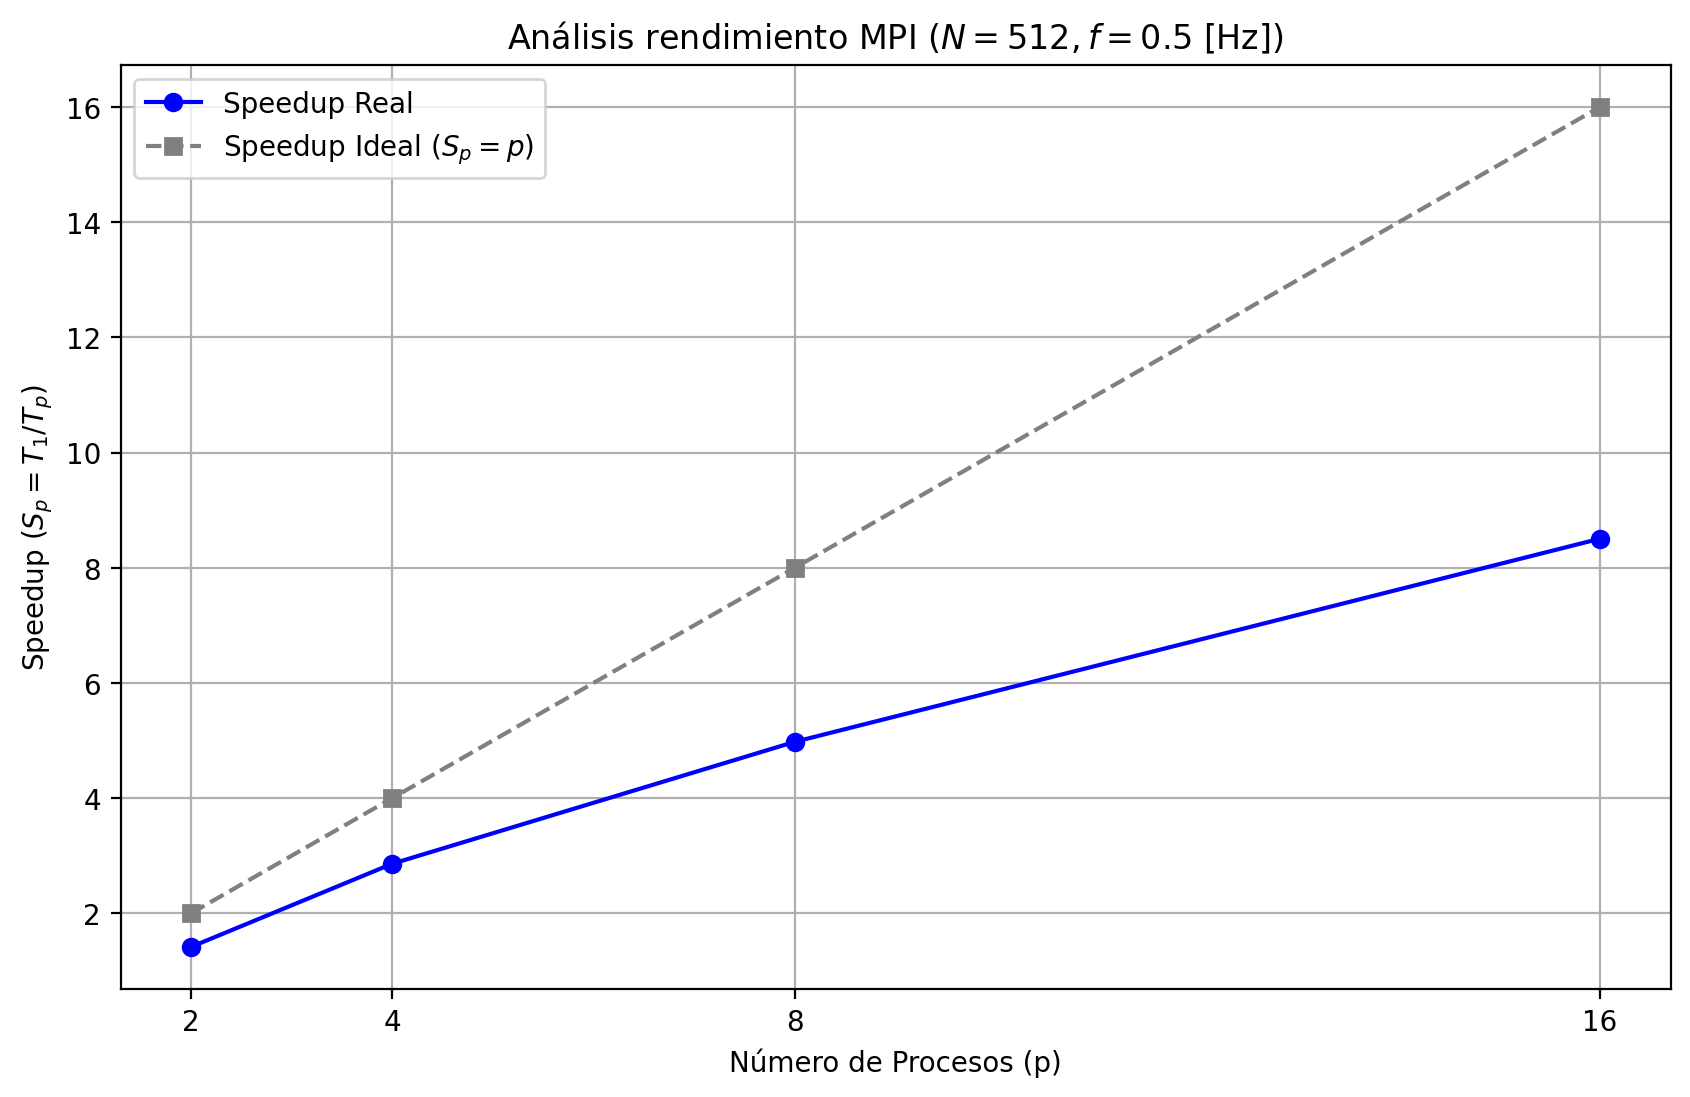

In [10]:
if times_p:
    p_list = sorted(times_p.keys())
    T_p_list = [times_p[p] for p in p_list]
    speedup_list = [T_1_f1 / T_p for T_p in T_p_list]

    ideal_speedup = [p for p in p_list]

    plt.figure(figsize=(10, 6))
    plt.plot(p_list, speedup_list, 'o-', label='Speedup Real', color='blue')
    plt.plot(p_list, ideal_speedup, 's--', label=r'Speedup Ideal ($S_p = p$)', color='gray')
    plt.xlabel('Número de Procesos (p)')
    plt.xticks(p_list)
    plt.ylabel(r'Speedup ($S_p = T_1 / T_p$)')
    plt.title('Análisis rendimiento MPI ($N = 512, f = 0.5$ [Hz])')
    plt.legend()
    plt.grid(True)
    plt.xticks(p_list)
    plt.show();

### Discusión del rendimiento

## 5. Médoto implícito (Crank-Nicholson)

### Formulación numérica (método implícito Crank-Nicholson)

En el primer punto de la tarea, se desarrolló la formulación numérica del método explícito para resolver la ecuación de calor en 2D con una fuente de calor variable en el tiempo. Ahora, se presentará la formulación numérica del método implícito (Crank-Nicholson) para el mismo problema.

Para ello, lo primero que se hizo fue discretizar la derivada temporal $\frac{\partial T}{\partial t}$ utilizando la diferencia finita hacia adelante. Luego, evaluamos todo el lado derecho (el Laplaciano ($\nabla^2 T$) y la fuente de calor ($S(x, y, t)$)) en el tiempo conocido $n$:
$$
\frac{\partial T}{\partial t} \approx \frac{T_{i,j}^{n+1} - T_{i,j}^n}{\Delta t} = \alpha \left( \nabla^2 T \right)_{i,j}^{n} + S_{i,j}^{n}
$$

Posteriormente, despejamos $T_{i,j}^{n+1}$, el único término desconocido en la ecuación y obtuvimos una fórmula explícita para calcular la temperatura en el siguiente paso de tiempo basándonos únicamente en los valores conocidos en el tiempo actual. Su gran desventaja es el criterio de estabilidad ($\Delta t \leq \frac{h^2}{4\alpha} \lor \mu \leq \frac{1}{4}$) que limita el tamaño del paso temporal $\Delta t$ con el fin de mantener la estabilidad numérica.

El método de Crank-Nicholson es un método implícito que mejora la estabilidad, puesto que es incondicionalmente estable. Su idea fundamental es ser "centrado en el tiempo". Esto significa que en lugar de evaluar el lado derecho de la ecuación (el Laplaciano $\nabla^2 T$ y la fuente de calor $S(x, y, t)$) únicamente en el tiempo conocido $n$ o en el tiempo $n+1$, C-N lo evalúa como el promedio de ambos tiempos:
$$
\frac{\partial T}{\partial t} \approx \frac{T_{i,j}^{n+1} - T_{i,j}^n}{\Delta t} = \alpha \cdot \frac{1}{2} \left[ \left( \nabla^2 T \right)_{i,j}^{n} + S_{i,j}^{n} \right] + \frac{1}{2} \left( \left( \nabla^2 T \right)_{i,j}^{n+1} + S_{i,j}^{n+1} \right)
$$
donde el lado izquierdo representa la derivada temporal aproximada y es la misma que en el método explícito y el lado derecho es el promedio del Laplaciano y la fuente de calor en los tiempos $n$ y $n+1$, por lo que contiene términos conocidos ($n$) y desconocidos ($n+1$).

Esto significa que $T_{i,j}^{n+1}$ ya no se puede despejar directamente, ya que aparece en ambos lados de la ecuación. El valor de la celda ($i, j$) en el tiempo $n+1$ depende de su propio valor futuro y de los valores futuros de sus vecinos. Por lo tanto, se debe resolver un sistema de ecuaciones lineales para encontrar todos los valores de $T_{i,j}^{n+1}$ simultáneamente.

Por lo tanto, utilizaremos la misma discretización espacial que en el método explícito, pero ahora aplicando la formulación de Crank-Nicholson. La discretización del Laplaciano en 2D es (asumiendo una malla uniforme con $h = \Delta x = \Delta y$):

$$
\left( \nabla^2 T \right)_{i,j} \approx \frac{T_{i+1,j} + T_{i-1,j} + T_{i,j+1} + T_{i,j-1} - 4T_{i,j}}{h^2}
$$

Antes de sustituir en la ecuación de Crank-Nicholson, definimos $\mu' = \frac{\alpha \Delta t}{2h^2}$ para simplificar la notación. Luego, sustituyendo la discretización del Laplaciano y la definición de $\mu$ en la ecuación de Crank-Nicholson, obtenemos:
$$
\begin{align*}
\frac{T_{i,j}^{n+1} - T_{i,j}^n}{\Delta t} 
&= \mu' \left[ \left( T_{i+1,j}^n + T_{i-1,j}^n + T_{i,j+1}^n + T_{i,j-1}^n - 4T_{i,j}^n \right) + S_{i,j}^n \right] + \\
&\quad \mu' \left[ \left( T_{i+1,j}^{n+1} + T_{i-1,j}^{n+1} + T_{i,j+1}^{n+1} + T_{i,j-1}^{n+1} - 4T_{i,j}^{n+1} \right) + S_{i,j}^{n+1} \right]
\end{align*}
$$
$$
\begin{align*}
T_{i,j}^{n+1} - T_{i,j}^n
&= \mu' \left[ T_{i+1,j}^n + T_{i-1,j}^n + T_{i,j+1}^n + T_{i,j-1}^n - 4T_{i,j}^n \right] + \\
&\quad \mu' \left[ T_{i+1,j}^{n+1} + T_{i-1,j}^{n+1} + T_{i,j+1}^{n+1} + T_{i,j-1}^{n+1} - 4T_{i,j}^{n+1} \right] + \frac{\Delta t}{2} \left( S_{i,j}^n + S_{i,j}^{n+1} \right)
\end{align*}
$$

Ahora, reordenamos los términos para agrupar los términos desconocidos $T_{i,j}^{n+1}$ en el lado izquierdo y los términos conocidos $T_{i,j}^n$ en el lado derecho:

- Lado izquierdo (términos en $n+1$):
$$
\begin{align*}
T_{i,j}^{n+1} - \mu' \left( T_{i+1,j}^{n+1} + T_{i-1,j}^{n+1} + T_{i,j+1}^{n+1} + T_{i,j-1}^{n+1} - 4T_{i,j}^{n+1} \right) \\
(1 + 4\mu') T_{i,j}^{n+1} - \mu' \left( T_{i+1,j}^{n+1} + T_{i-1,j}^{n+1} + T_{i,j+1}^{n+1} + T_{i,j-1}^{n+1} \right)
\end{align*}
$$

- Lado derecho (términos en $n$):
$$
\begin{align*}
T_{i,j}^n + \mu' \left( T_{i+1,j}^n + T_{i-1,j}^n + T_{i,j+1}^n + T_{i,j-1}^n - 4T_{i,j}^n \right) + \frac{\Delta t}{2} \left( S_{i,j}^n + S_{i,j}^{n+1} \right) \\
(1 - 4\mu') T_{i,j}^n + \mu' \left( T_{i+1,j}^n + T_{i-1,j}^n + T_{i,j+1}^n + T_{i,j-1}^n \right) + \frac{\Delta t}{2} \left( S_{i,j}^n + S_{i,j}^{n+1} \right)
\end{align*}
$$

La derivación anterior es una sola fila de este sistema de ecuaciones lineales. Consideremos que la malla tiene $N \times N$ puntos, con $N=512$. Entonces, tenemos $(N-2)^{2} = 510^{2} = 260100$ celdas internas que son desconocidas. Por lo tanto, debemos escribir $260100$ ecuaciones similares a la anterior, una para cada celda interna, y organizarlas en una forma matricial.

De este modo, el vector de incógnitas $\vec{T}^{n+1}$ tendrá la siguiente forma:
$$
\vec{T}^{n+1} = \left[T_{1,1}^{n+1}, T_{1,2}^{n+1}, \ldots, T_{1,N-2}^{n+1}, T_{2,1}^{n+1}, T_{2,2}^{n+1}, \ldots, T_{N-2,N-2}^{n+1}\right]^{T}
$$

La matriz de coeficientes $A$ es una matriz gigante de $M \times M$, donde $M = (N-2)^{2} = 260100$. Cada fila $k$ de esta matriz (que corresponde a la celda interna $(i,j)$) se construye a partir del lado izquierdo de la ecuación derivada anteriormente. Los elementos de la fila $k$ son:
- El elemento de la diagonal ($A_{k,k}$) es el coeficiente de $T_{i,j}^{n+1}$, que es $(1 + 4\mu')$.
- Los elementos fuera de la diagonal corresponden a los coeficientes de las celdas vecinas $T_{i+1,j}^{n+1}$, $T_{i-1,j}^{n+1}$, $T_{i,j+1}^{n+1}$ y $T_{i,j-1}^{n+1}$, que son todos $-\mu'$. Si una celda vecina está fuera de los límites (por ejemplo, en los bordes), no se incluye en la fila.

Esta matriz es muy dispersa (sparse), ya que cada fila tiene a lo sumo 5 elementos no nulos (el elemento diagonal y hasta 4 elementos correspondientes a las celdas vecinas).

Por último, el vector del lado derecho $\vec{b}$, de tamaño $M$, se construye a partir del lado derecho de la ecuación derivada anteriormente. Cada elemento $b_k$ del vector corresponde a la celda interna $(i,j)$ y se calcula como:
$$
b_{k} = (1 - 4\mu') T_{i,j}^n + \mu' \left( T_{i+1,j}^n + T_{i-1,j}^n + T_{i,j+1}^n + T_{i,j-1}^n \right) + \frac{\Delta t}{2} \left( S_{i,j}^n + S_{i,j}^{n+1} \right)
$$

Entonces, el sistema de ecuaciones lineales resultante se puede escribir en forma matricial como:
$$
A \cdot \vec{T}^{n+1} = \vec{b}
$$
donde, para cada paso de tiempo, debemos construir la matriz $A$ (que permanece constante si $\mu'$ no cambia), calcular el vector $\vec{b}$ basado en el estado actual $\vec{T}^{n}$ y resolver el sistema lineal $A \cdot \vec{T}^{n+1} = \vec{b}$ para obtener la nueva distribución de temperatura $\vec{T}^{n+1}$.

### Resolución del sistema de ecuaciones lineales

In [21]:
## Funciones auxiliares para el método implícito
def build_sparse_matrix_A(N_internal:int, mu_prima:float) -> scipy.sparse.csc_matrix:
    """
    Construye la matriz A (LHS) del sistema Crank-Nicholson.
    A es una matriz dispersa penta-diagonal.
    """

    M = N_internal * N_internal
    
    # Coeficientes de la matriz A
    c_diag = 1.0 + 4.0 * mu_prima
    c_off_xy = -mu_prima

    # Diagonal principal (coeficiente de T_ij^(n+1))
    diag_0 = np.full(M, c_diag)

    # Diagonales vecinas (X) (coeficientes de T_i,j-1 y T_i,j+1)
    diag_1 = np.full(M - 1, c_off_xy)
    # Evitar "wrap-around" al final de una fila
    diag_1[N_internal - 1::N_internal] = 0.0

    diag_m1 = np.full(M - 1, c_off_xy)
    diag_m1[N_internal - 1::N_internal] = 0.0

    # Diagonales lejanas (Y) (coeficientes de T_i-1,j y T_i+1,j)
    diag_N = np.full(M - N_internal, c_off_xy)
    diag_mN = np.full(M - N_internal, c_off_xy)

    diagonals = [diag_mN, diag_m1, diag_0, diag_1, diag_N]
    offsets = [-N_internal, -1, 0, 1, N_internal]

    # Construcción de la matriz dispersa A en formato CSR (eficiente para spsolve)
    A = scipy.sparse.diags(diagonals, offsets, shape=(M, M), format='csc')
    return A

def build_vector_b(T: np.ndarray, S_n: np.ndarray, S_n1: np.ndarray, mu_prima: float, 
                   dt: float) -> np.ndarray:
    """
    Construye el vector b (RHS) del sistema C-N, basado en el estado T^n.
    b = T^n + mu'(...T^n...) + (dt/2)(S^n + S^{n+1})
    """
    
    # Extraer la parte interna de T (sin bordes)
    T_internal = T[1:-1, 1:-1]

    # Calcular el Laplaciano en el tiempo n (solo puntos internos)
    T_laplacian_n = (
        T[2:,   1:-1] +     # T(i+1, j)
        T[0:-2, 1:-1] +     # T(i-1, j)
        T[1:-1, 2:  ] +     # T(i, j+1)
        T[1:-1, 0:-2]       # T(i, j-1)
    )

    # Calcular el lado derecho
    # b = (1 - 4*mu')*T^n + mu' * Laplaciano(T^n) + (dt/2)(S^n + S^{n+1})
    b_2d = ( (1.0 - 4.0 * mu_prima) * T_internal + mu_prima * T_laplacian_n)

    # Agregar el término fuente
    S_avg = (S_n[1:-1, 1:-1] + S_n1[1:-1, 1:-1]) * (dt / 2.0)
    b_2d += S_avg

    # Aplanar el vector 2D (N-2, N-2) a un vector 1D (M)
    return b_2d.flatten()

# Función de simulación implícita (Crank-Nicholson)
def run_simulation_cn(N: int, L: float, alpha: float, dt: float, t_final: float, f: float,
                      use_optimized_solver: bool = False) -> tuple:
    """
    Ejecuta la simulación implícita (Crank-Nicholson) de transferencia de calor.
    """
    h = L / N
    n_steps = int(t_final / dt)
    mu_prima = (alpha * dt) / (2 * (h**2)) # mu' = alpha*dt / (2*h^2)

    print(f"Ejecutando método Crank-Nicholson con f = {f} Hz...\n")
    if use_optimized_solver:
        print("Modo optimizado (pre-factorización LU)")
    else:
        print("Modo estándar (resolución directa en cada paso)")
    
    print(f"dt = {dt:.2e} [s], Pasos = {n_steps}, mu' = {mu_prima:.4f}")

    # Inicialización de la grilla de temperatura
    N_internal = N - 2
    M = N_internal * N_internal
    T = np.zeros((N, N), dtype=np.float64)

    # Máscara espacial para S(x, y, t)
    i_min, i_max = int(0.4 * N), int(0.6 * N)
    j_min, j_max = int(0.4 * N), int(0.6 * N)
    S_mask = np.zeros((N, N), dtype=np.float64)
    S_mask[i_min:i_max, j_min:j_max] = 145.0

    # Historial de tiempo y temperatura en el centro
    T_center_history = np.zeros(n_steps)
    time_history = np.zeros(n_steps)
    T_center_idx = N // 2

    # Construcción de la matriz A dispersa
    print("\nConstruyendo matriz A dispersa...")
    start_build_time = time.time()
    A_sparse = build_sparse_matrix_A(N_internal, mu_prima)
    end_build_time = time.time()
    total_build_time = end_build_time - start_build_time
    print(f"Matriz A ({M}x{M}) construida en {total_build_time:.4f} s.")

    A_solver = None
    if use_optimized_solver:
        print("Factorizando matriz A (splu)...")
        start_factor_time = time.time()
        A_solver = splu(A_sparse)
        end_factor_time = time.time()
        total_factor_time = end_factor_time - start_factor_time
        print(f"Matriz A factorizada en {total_factor_time:.4f} s.\n")

    start_sim_time = time.time()
    for n in range(n_steps):
        t = n * dt
        
        Pt_n = P(t, f)
        Pt_n1 = P(t + dt, f)
        S_n = S_mask * Pt_n
        S_n1 = S_mask * Pt_n1

        b_flat = build_vector_b(T, S_n, S_n1, mu_prima, dt)
        
        try:
            if A_solver:
                T_flat_next = A_solver.solve(b_flat, trans='N')
            else:
                T_flat_next = spsolve(A_sparse, b_flat)
        except Exception as e:
            print(f"Error al resolver el sistema en el paso {n}: {e}")
            break

        T[1:-1, 1:-1] = T_flat_next.reshape((N_internal, N_internal))
        T_center_history[n] = T[T_center_idx, T_center_idx]
        time_history[n] = t

    T_exec = time.time() - start_sim_time
    print(f"Simulación C-N completa en {T_exec:.2f} segundos ({T_exec/60:.2f} minutos).")
    print("="*100)
    return T_exec, time_history, T_center_history

In [25]:
N = 512             # Resolución de la grilla
L = 0.05            # Largo de la placa [m]
alpha = 1.1e-4      # Difusividad térmica del cobre [m^2/s]

dt = 2.0e-5         # Paso del tiempo [s]
dt_10 = 2.0e-4      # 10x Paso del tiempo [s]
dt_100 = 2.0e-3     # 100x Paso del tiempo [s]
dt_1000 = 2.0e-2    # 1000x Paso del tiempo [s]

t_final = 5         # Tiempo de simulación
f_2 = 10            # Frecuencia de la carga lenta [Hz]

# T_exec_cn, time_cn, temp_cn = run_simulation_cn(N, L, alpha, dt, t_final, f_2, use_optimized_solver=True)
T_exec_cn_10, time_cn_10, temp_cn_10 = run_simulation_cn(N, L, alpha, dt_10, t_final, f_2, use_optimized_solver=True)
T_exec_cn_100, time_cn_100, temp_cn_100 = run_simulation_cn(N, L, alpha, dt_100, t_final, f_2, use_optimized_solver=True)
T_exec_cn_1000, time_cn_1000, temp_cn_1000 = run_simulation_cn(N, L, alpha, dt_1000, t_final, f_2, use_optimized_solver=True)

Ejecutando método Crank-Nicholson con f = 10 Hz...

Modo optimizado (pre-factorización LU)
dt = 2.00e-04 [s], Pasos = 25000, mu' = 1.1534

Construyendo matriz A dispersa...
Matriz A (260100x260100) construida en 0.0163 s.
Factorizando matriz A (splu)...
Matriz A factorizada en 1.0659 s.

Simulación C-N completa en 1080.09 segundos (18.00 minutos).
Ejecutando método Crank-Nicholson con f = 10 Hz...

Modo optimizado (pre-factorización LU)
dt = 2.00e-03 [s], Pasos = 2500, mu' = 11.5343

Construyendo matriz A dispersa...
Matriz A (260100x260100) construida en 0.0136 s.
Factorizando matriz A (splu)...
Matriz A factorizada en 1.0451 s.

Simulación C-N completa en 107.42 segundos (1.79 minutos).
Ejecutando método Crank-Nicholson con f = 10 Hz...

Modo optimizado (pre-factorización LU)
dt = 2.00e-02 [s], Pasos = 250, mu' = 115.3434

Construyendo matriz A dispersa...
Matriz A (260100x260100) construida en 0.0145 s.
Factorizando matriz A (splu)...
Matriz A factorizada en 1.0281 s.

Simulación C-

In [27]:
print("-------- COMPARACIÓN DE TIEMPOS DE EJECUCIÓN --------")
print(f"Método        | dt (s)   | Pasos   | T. Ejecución (s)")
print(f"--------------|----------|---------|-----------------")
# print(f"C-N (1x)     | {dt:8.2e} | {len(time_cn):<7} | {T_exec_cn:15.2f}")
print(f"C-N (10x)     | {dt_10:8.2e} | {len(time_cn_10):<7} | {T_exec_cn_10:15.2f}")
print(f"C-N (100x)    | {dt_100:8.2e} | {len(time_cn_100):<7} | {T_exec_cn_100:15.2f}")
print(f"C-N (1000x)   | {dt_1000:8.2e} | {len(time_cn_1000):<7} | {T_exec_cn_1000:15.2f}")

-------- COMPARACIÓN DE TIEMPOS DE EJECUCIÓN --------
Método        | dt (s)   | Pasos   | T. Ejecución (s)
--------------|----------|---------|-----------------
C-N (10x)     | 2.00e-04 | 25000   |         1080.09
C-N (100x)    | 2.00e-03 | 2500    |          107.42
C-N (1000x)   | 2.00e-02 | 250     |           10.78


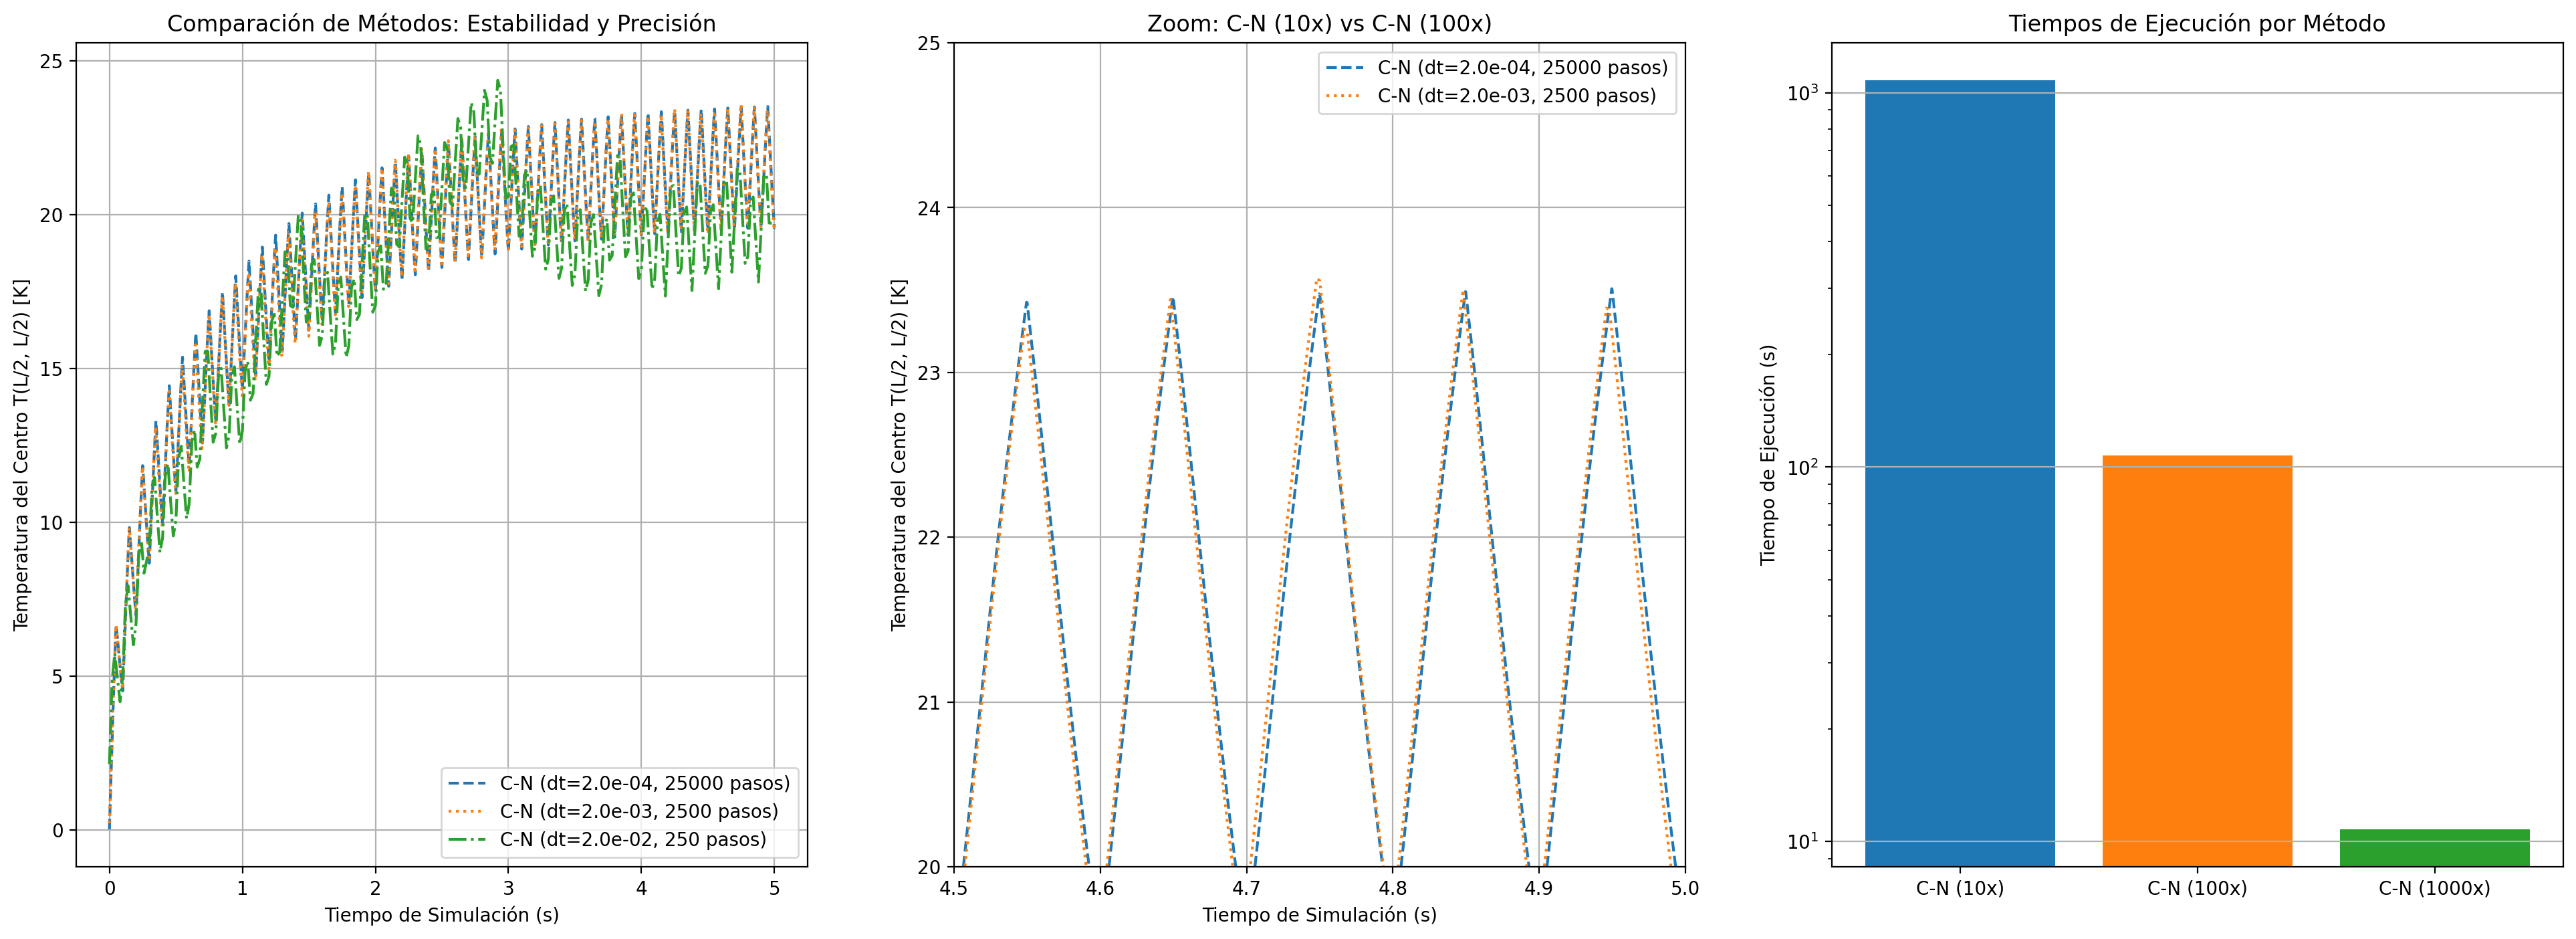

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# plt.plot(time_cn, temp_cn, label=f'C-N (dt={dt:.1e}, {len(time_cn)} pasos)', alpha=0.8)
ax[0].plot(time_cn_10, temp_cn_10, label=f'C-N (dt={dt_10:.1e}, {len(time_cn_10)} pasos)', linestyle='--')
ax[0].plot(time_cn_100, temp_cn_100, label=f'C-N (dt={dt_100:.1e}, {len(time_cn_100)} pasos)', linestyle=':')
ax[0].plot(time_cn_1000, temp_cn_1000, label=f'C-N (dt={2.0e-2:.1e}, {len(time_cn_1000)} pasos)', linestyle='-.')


ax[0].set_title('Comparación de Métodos: Estabilidad y Precisión')
ax[0].set_xlabel('Tiempo de Simulación (s)')
ax[0].set_ylabel('Temperatura del Centro T(L/2, L/2) [K]')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(time_cn_10, temp_cn_10, label=f'C-N (dt={dt_10:.1e}, {len(time_cn_10)} pasos)', linestyle='--')
ax[1].plot(time_cn_100, temp_cn_100, label=f'C-N (dt={dt_100:.1e}, {len(time_cn_100)} pasos)', linestyle=':')
ax[1].set_title('Zoom: C-N (10x) vs C-N (100x)')
ax[1].set_xlim(4.5, 5.0)
ax[1].set_xlabel('Tiempo de Simulación (s)')
ax[1].set_ylim(20, 25)
ax[1].set_ylabel('Temperatura del Centro T(L/2, L/2) [K]')
ax[1].legend()
ax[1].grid(True)


ax[2].bar(['C-N (10x)', 'C-N (100x)', 'C-N (1000x)'], 
          [T_exec_cn_10, T_exec_cn_100, T_exec_cn_1000], 
          color=['tab:blue', 'tab:orange', 'tab:green'])
ax[2].set_title('Tiempos de Ejecución por Método')
ax[2].set_ylabel('Tiempo de Ejecución (s)')
ax[2].grid(axis='y')
ax[2].set_yscale('log')

plt.savefig('./media/comparacion_metodos_punto5.png')

Cabe destacar que la primera implementación del método implícito Crank-Nicholson se realizó utilizando la librería `scipy.sparse` para manejar la matriz dispersa $A$ y `scipy.sparse.linalg.spsolve` para resolver el sistema de ecuaciones lineales. Esta implementación resultó ser muy lenta debido al gran tamaño de la matriz (260100 x 260100) y la complejidad computacional asociada con la resolución de sistemas lineales grandes, incluso utilizando métodos para matrices dispersas, donde, por ejemplo, al ejecutar la simulación con $N=512$ y $t_{final}=5s$, con un paso temporal $\Delta t = 2.0 \times 10^{-3} s$ (100 veces superior que en el método explícito), se demoró más de 50 minutos en ejecutarse, donde el valor final del tiempo de ejecución es desconocido ya que la simulación fue interrumpida manualmente.

Por lo tanto, para mejorar el rendimiento, se utilizó la función `scipy.sparse.linalg.splu` para realizar la factorización LU de la matriz $A$, lo que permite resolver el sistema de manera más eficiente en pasos posteriores. Esto permitió reducir significativamente el tiempo de ejecución de la simulación. Con esta optimización, la simulación con los mismos parámetros mencionados anteriormente se completó en aproximadamente 2 minutos, lo que representa una mejora sustancial en el rendimiento.

### Discusión de resultados

#### **Trade-off** entre costo computacional por paso y el tamaño del paso temporal

#### ¿Por qué no se puede paralelizar el método implícito Crank-Nicholson de la misma manera que el método explícito?

## 6. Análisis físico y multimedia

### Animación de la evolución de la temperatura 2D a lo largo del tiempo

### Graficar la temperatura del punto más caliente T(L/2, L/2, t) en función del tiempo, superpuesta con la función de pontencia P(t) para ambas frecuencias.

In [15]:
# # convertir
# !jupyter nbconvert --to html "Tarea2_FZ.ipynb"

# # abrir el HTML generado en el navegador por defecto (Windows)
# !start "Tarea2_FZ.html"

## 7. Referencias

<a id="ref-landau"></a> [1] R. Landau, M. Páez, y C. Bordeianu, *Computational Physics: Problem Solving with Python*.  
  Disponible en: [https://sites.science.oregonstate.edu/~landaur/Books/CPbook/](https://sites.science.oregonstate.edu/~landaur/Books/CPbook/)